# **Analysis of decoding results**

## **Libraries**

In [3]:
#%pip install pandas matplotlib seaborn nltk

In [35]:
import os
import re
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import nltk

import constants

## **Directories**

In [5]:
DATA_FOLDER = constants.DATA_FOLDER

DECODED_OUTPUTS = os.path.join(DATA_FOLDER, 'first_decode_checkpoint_100-50.log')
REFERENCE_SOURCE_GN = os.path.join(DATA_FOLDER, 'first_val_gn.txt')
REFERENCE_DESTINATION_ES = os.path.join(DATA_FOLDER, 'first_val_es.txt')

In [6]:
with open(REFERENCE_SOURCE_GN, 'r', encoding='utf-8') as f:
    reference_source_gn = f.readlines()

with open(REFERENCE_DESTINATION_ES, 'r', encoding='utf-8') as f:
    reference_destination_es = f.readlines()

with open(DECODED_OUTPUTS, 'r', encoding='utf-8') as f:
    decoded_outputs = f.readlines()

## **Checking the files**

In [7]:
print(f'Number of lines in reference source: {len(reference_source_gn)}')
print(f'Number of lines in reference destination: {len(reference_destination_es)}')
print(f'Number of lines in decoded outputs: {len(decoded_outputs)}')

Number of lines in reference source: 4939
Number of lines in reference destination: 4939
Number of lines in decoded outputs: 4938


There is a difference of 1 between the number of lines in the decoded outputs and the number of lines in the original inputs.

In [8]:
for idx, (elem_ref, elem_dest, decoded) in enumerate(zip(reference_source_gn, reference_destination_es, decoded_outputs)):
    if elem_ref.strip() == '':
        print(f'Empty line at index {idx} from reference source')

    if elem_dest.strip() == '':
        print(f'Empty line at index {idx} from reference destination')

    if decoded.strip() == '':
        print(f'Empty line at index {idx} from decoded outputs')

Empty line at index 1188 from decoded outputs


This extra line is not a problem, as the decoded file can output empty lines. However, it remains unclear why the length of the files are different.

## **Score analysis**

### **Examples of BLEU score**

In [63]:
def silence_warnings(func):
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return func(*args, **kwargs)
    return wrapper

In [64]:
correct_reference = ['Today', 'is', 'a', 'new', 'day']
short_reference = ['Today']
wrong_reference = ['Yesterday', 'was', 'a', 'good', 'day']

translated = ['Today', 'is', 'a', 'new', 'day']

@silence_warnings
def show_bleu_example(reference, translated):
    bleu_score = nltk.translate.bleu_score.sentence_bleu([reference], translated)
    bleu_score_1gram = nltk.translate.bleu_score.sentence_bleu([reference], translated, weights=(1, 0, 0, 0))
    print(f'BLEU score of {bleu_score} for: \n{reference} \n{translated}')
    print(f'1-gram BLEU score of {bleu_score_1gram}', end='\n\n')

for reference in [correct_reference, short_reference, wrong_reference]:
    show_bleu_example(reference, translated)

BLEU score of 1.0 for: 
['Today', 'is', 'a', 'new', 'day'] 
['Today', 'is', 'a', 'new', 'day']
1-gram BLEU score of 1.0

BLEU score of 1.2183324802375697e-231 for: 
['Today'] 
['Today', 'is', 'a', 'new', 'day']
1-gram BLEU score of 0.2

BLEU score of 1.4488496539373276e-231 for: 
['Yesterday', 'was', 'a', 'good', 'day'] 
['Today', 'is', 'a', 'new', 'day']
1-gram BLEU score of 0.4



### **Show BLEU score distribution**

In [76]:
@silence_warnings
def calculate_BLEU_score(reference_destination, decoded_outputs):
    bleu_scores = []
    bleu_scores_1gram = []

    for idx, (dest_ref, decoded) in enumerate(zip(reference_destination, decoded_outputs)):
        # Tokenized by spaces because of the lack of a guarani tokenizer
        tokenized_ref = dest_ref.strip().split(' ')
        tokenized_decoded = decoded.strip().split(' ')
        bleu_score = nltk.translate.bleu_score.sentence_bleu([tokenized_ref], tokenized_decoded)
        bleu_score_1gram = nltk.translate.bleu_score.sentence_bleu([tokenized_ref], tokenized_decoded, weights=(1, 0, 0, 0))
        bleu_scores.append(bleu_score)
        bleu_scores_1gram.append(bleu_score_1gram)

    return bleu_scores, bleu_scores_1gram

In [140]:
bleu_scores, bleu_scores_1gram = calculate_BLEU_score(reference_destination_es, decoded_outputs)

In [145]:
percentage_bleu_scores = [score * 100 for score in bleu_scores]
score_summary = pd.DataFrame({'BLEU score': bleu_scores, '1-gram BLEU score': bleu_scores_1gram, 'Percentage BLEU score': percentage_bleu_scores})
#show numeric values with commas
score_summary.describe().applymap('{:,.5f}'.format)

,BLEU score,1-gram BLEU score,Percentage BLEU score
count,"4,938.00000","4,938.00000","4,938.00000"
mean,0.00289,0.10831,0.28894
std,0.03333,0.09874,3.33282
min,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000
50%,0.00000,0.10256,0.00000
75%,0.00000,0.16345,0.00000
max,1.00000,1.00000,100.00000


This does not align with the BLEU score returned by marian.

TODO: Sentences shorter than 4 words are not well-suited for BLEU scoring.

In [93]:
limit = 3
zipped_scores = list(zip(reference_source_gn, reference_destination_es, decoded_outputs, bleu_scores))
for zipped_score in zipped_scores[:limit]:
    for text in zipped_score:
        if type(text) == str:
            print(str(text)[:-1])
        else:
            print(text)
    print()

ñemosẽ
Expulsar
deficiencia
0

Jepe héra he'i, Snake River ndorekói mbói ipype.Héra upéicha ikoni rupi S-icha.
A pesar de su nombre, en Snake River no hay serpientes; se llama así por su forma de S.
Sin embargo, no le “encantaría no ser esperar sin embargo, la carne paraguaya o por "vendido".
8.980605341426996e-232

Cartista-kuéra oñeha’ã banca oike Asociación Nacional Republicana (ANR), péva correligionario Ramón Retamozo.
Cartistas insisten en que la banca le corresponde a la Asociación Nacional Republicana (ANR), específicamente a su correligionario Ramón Retamozo.
Tras su discurso en el Partido Liberal Radical Auténtico (PLRA), anunció que el acuerdo fue presentado en la Cámara Baja.
1.2183324802375697e-231



In [127]:
def plot_scores(scores, title, xlabel):
    sns.set_style('darkgrid')
    ax = sns.displot(scores, kind='kde', fill=True)
    ax.set(xlabel=xlabel, ylabel='Density', title=title)

Number of positive BLEU scores: 4938
Number of BLEU scores greater than epsilon: 73
Number of acceptable BLEU scores: 13


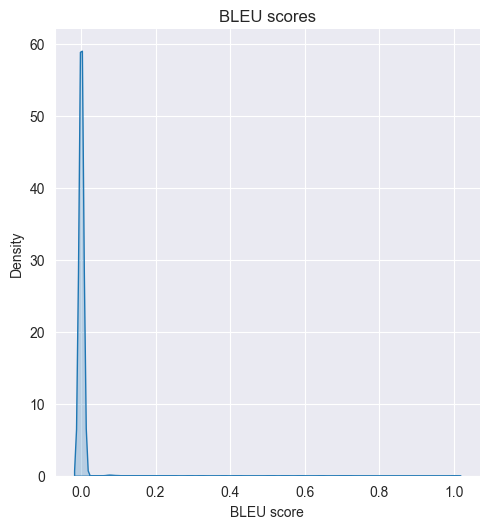

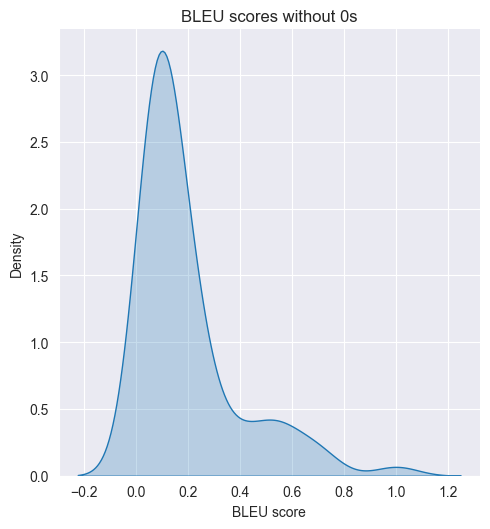

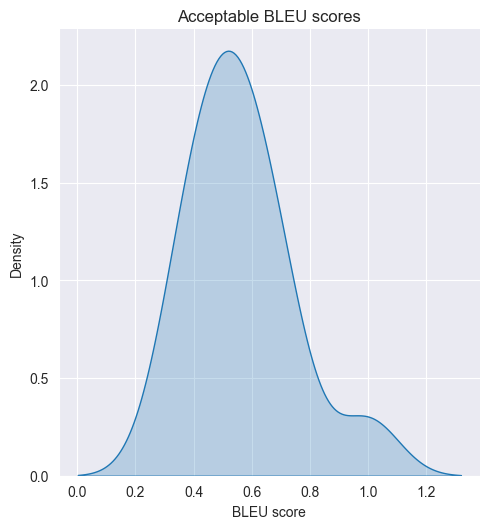

In [131]:
acceptance_threshold = 0.3
epsilon = 0.0001

non_negligible_bleu_scores = [score for score in bleu_scores if score > epsilon]
acceptable = [score for score in bleu_scores if score > acceptance_threshold]

print(f'Number of positive BLEU scores: {len(bleu_scores)}')
plot_scores(bleu_scores, 'BLEU scores', 'BLEU score')

print(f'Number of BLEU scores greater than epsilon: {len(non_negligible_bleu_scores)}')
plot_scores(non_negligible_bleu_scores, 'BLEU scores without 0s', 'BLEU score')

print(f'Number of acceptable BLEU scores: {len(acceptable)}')
plot_scores(acceptable, 'Acceptable BLEU scores', 'BLEU score')

### **Better BLEU scores**

In [136]:
def get_ordered_score_indexes(scores, best=True, limit=3):
    return sorted(range(len(scores)), key=lambda i: scores[i], reverse=best)[:limit]

def show_translations(indexes, reference_source, reference_destination, decoded_outputs):
    for idx in indexes:
        print()
        print(f'Index: {idx}')
        print(f'Reference source: {reference_source[idx][:-1]}')
        print(f'Reference destination: {reference_destination[idx][:-1]}')
        print(f'Decoded output: {decoded_outputs[idx]}')
        reference_destination_tokens = set(reference_destination[idx].strip().split(' '))
        decoded_output_tokens = set(decoded_outputs[idx].strip().split(' '))
        print(f'Reference destination tokens: {reference_destination_tokens}')
        print(f'Decoded output tokens: {decoded_output_tokens}')
        overlapping_words = reference_destination_tokens.intersection(decoded_output_tokens)
        print(f'Overlapping words: {overlapping_words}')
        print('------------------')

In [146]:
best_indexes = get_ordered_score_indexes(bleu_scores, best=True, limit=10)
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs)


Index: 1610
Reference source: pe aranduka morotĩ
Reference destination: el libro es blanco.
Decoded output: el libro es blanco.

Reference destination tokens: {'blanco.', 'libro', 'el', 'es'}
Decoded output tokens: {'blanco.', 'libro', 'el', 'es'}
Overlapping words: {'blanco.', 'libro', 'el', 'es'}
------------------

Index: 2717
Reference source: OÑEMBOSAKO'I AMANDAJE GUASU ÑE'Ẽ RAPEREKA PARAGUÁIPE REHEGUA.
Reference destination: ORGANIZAN II SEMINARIO-TALLER SOBRE INVESTIGACIÓN LINGŨÍSTICA EN PARAGUAY.
Decoded output: SEMINARIO-TALLER SOBRE INVESTIGACIÓN LINGŨÍSTICA EN PARAGUAY.

Reference destination tokens: {'EN', 'SOBRE', 'LINGŨÍSTICA', 'PARAGUAY.', 'INVESTIGACIÓN', 'SEMINARIO-TALLER', 'ORGANIZAN', 'II'}
Decoded output tokens: {'EN', 'SOBRE', 'LINGŨÍSTICA', 'PARAGUAY.', 'INVESTIGACIÓN', 'SEMINARIO-TALLER'}
Overlapping words: {'EN', 'SOBRE', 'LINGŨÍSTICA', 'PARAGUAY.', 'INVESTIGACIÓN', 'SEMINARIO-TALLER'}
------------------

Index: 4024
Reference source: TEMBIAPORÃ'ATY “ROHAYHU CH

Curiosidad: En el índice 3488 confunde la palabra "igualdad" con "nosotros"... ¿Casualidad?

In [138]:
worst_indexes = get_ordered_score_indexes(bleu_scores, best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)


Index: 0
Reference source: ñemosẽ
Reference destination: Expulsar
Decoded output: deficiencia

Reference destination tokens: {'Expulsar'}
Decoded output tokens: {'deficiencia'}
Overlapping words: set()
------------------

Index: 5
Reference source: Haipy guaraníme ikatúva oñemboguejy reínte
Reference destination: Obras en guaraní para descargar gratis
Decoded output: En el siguiente panel fue un diccionario guaraní.

Reference destination tokens: {'descargar', 'para', 'Obras', 'en', 'gratis', 'guaraní'}
Decoded output tokens: {'guaraní.', 'un', 'siguiente', 'el', 'diccionario', 'panel', 'En', 'fue'}
Overlapping words: set()
------------------

Index: 9
Reference source: Uperiremi neakâguapy
Reference destination: Al rato te calmas
Decoded output: Concluyó diciendo

Reference destination tokens: {'rato', 'te', 'Al', 'calmas'}
Decoded output tokens: {'Concluyó', 'diciendo'}
Overlapping words: set()
------------------


### **¿What about the missing line?**

In [132]:
def plot_values_by_index(scores):
    sns.set_style('darkgrid')
    x = list(range(len(scores)))
    y = scores
    plt.plot(x, y)
    plt.show()

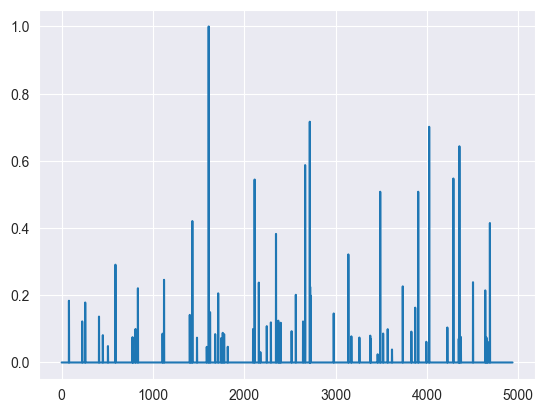

In [133]:
plot_values_by_index(bleu_scores)

Nothing seems to indicate that the missing line is causing problems...